# [ATM 623: Climate Modeling](../index.ipynb)

[Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany

# Lecture 9.5: Radiative-Convective Equilibrium

### About these notes:

This document uses the interactive [`IPython notebook`](http://ipython.org/notebook.html) format (now also called [`Jupyter`](https://jupyter.org)). The notes can be accessed in several different ways:

- The interactive notebooks are hosted on `github` at https://github.com/brian-rose/ClimateModeling_courseware
- The latest versions can be viewed as static web pages [rendered on nbviewer](http://nbviewer.ipython.org/github/brian-rose/ClimateModeling_courseware/blob/master/index.ipynb)
- A complete snapshot of the notes as of May 2015 (end of spring semester) are [available on Brian's website](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/Notes/index.html).

Many of these notes make use of the `climlab` package, available at https://github.com/brian-rose/climlab

## Contents

1. [A Radiative-Convective Model (RCM) using the RRTMG radiation module](#section1)
2. [Adjustment toward Radiative-Convective Equilibrium](#section2)
3. [Forcing and feedback in the RCM](#section3)
4. [The role of water vapor in the warming](#section4)
5. [Observed relative humidity profiles](#section5)
6. [Exercises on water vapor](#section6)

## Note on running this notebook

There is some code below that produces an animation interactively and displays the results in the notebook. For this to work, you may need to install [ffmpeg](http://ffmpeg.org), a piece of software that handles generating video.

On Mac, I like to use the package manager called [homebrew](https://brew.sh). I successfully got these animations working by doing
```
brew install ffmpeg
```

____________
<a id='section1'></a>

## 1. A Radiative-Convective Model (RCM) using the RRTMG radiation module
____________

`climlab` (as of version 0.5, Spring 2017) provides two different "GCM-level" radiation codes:

- The [CAM3 radiation module](http://climlab.readthedocs.io/en/latest/api/climlab.radiation.cam3.cam3.html) from NCAR (essentially the same radiation code used in our CESM slab ocean simulations)
- The [RRTMG (Rapid Radiative Transfer Model)](http://climlab.readthedocs.io/en/latest/api/climlab.radiation.rrtm.html) which is used in many current GCMs.

The links above take you to the online [climlab documentation](http://climlab.readthedocs.io/en/latest/intro.html).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import climlab
#  Some imports needed to make and display animations
from IPython.display import HTML
from matplotlib import animation

####  Here is an example of building a single-column RCM in climlab

In [2]:
import climlab
#  Choose the surface albedo
alb = 0.2
#  State variables (Air and surface temperature)
state = climlab.column_state(num_lev=50)
#  Parent model process
rcm = climlab.TimeDependentProcess(state=state)
#  Fixed relative humidity
h2o = climlab.radiation.ManabeWaterVapor(state=state)
#  Couple water vapor to radiation
rad = climlab.radiation.RRTMG(state=state, specific_humidity=h2o.q, albedo=alb)
#  Convective adjustment
conv = climlab.convection.ConvectiveAdjustment(state=state, adj_lapse_rate=6)
#  Couple everything together
rcm.add_subprocess('Radiation', rad)
rcm.add_subprocess('WaterVapor', h2o)
rcm.add_subprocess('Convection', conv)
#rcm.compute_diagnostics()

print rcm

Getting ozone data from /Users/br546577/code/climlab/climlab/data/ozone/apeozone_cam3_5_54.nc
climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Tatm: (50,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Convection: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
   WaterVapor: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>



For convenience we still have our handle to the `Radiation` subprocess:

In [3]:
rad is rcm.subprocess.Radiation

True

The `RRTMG` radiation module is actually comprised of two `subprocesses`:

In [4]:
print rad

climlab Process of type <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>. 
State variables and domain shapes: 
  Tatm: (50,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
   LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>



In [5]:
print rad.subprocess.LW

print rad.subprocess.SW

climlab Process of type <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>. 
State variables and domain shapes: 
  Tatm: (50,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>

climlab Process of type <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>. 
State variables and domain shapes: 
  Tatm: (50,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>



### What radiatively active gases are in this model?

They are defined in a dictionary that is shared with the `LW` and `SW` subprocesses:

In [6]:
#  Volumetric mixing ratios
rad.absorber_vmr

{'CCL4': 0.0,
 'CFC11': 0.0,
 'CFC12': 0.0,
 'CFC22': 0.0,
 'CH4': 1.65e-06,
 'CO2': 0.000348,
 'N2O': 3.06e-07,
 'O2': 0.21,
 'O3': array([  8.49933725e-06,   4.48576690e-06,   2.25137178e-06,
          1.13532298e-06,   6.61862588e-07,   4.41032900e-07,
          3.18477002e-07,   2.45552383e-07,   2.00235820e-07,
          1.66251001e-07,   1.37260417e-07,   1.14054576e-07,
          9.29020109e-08,   8.01070865e-08,   6.83827083e-08,
          6.34392413e-08,   5.84957744e-08,   5.57122567e-08,
          5.33033466e-08,   5.10772439e-08,   4.93420300e-08,
          4.76068161e-08,   4.60528063e-08,   4.48079957e-08,
          4.35631852e-08,   4.23784162e-08,   4.16341607e-08,
          4.08899052e-08,   4.01456497e-08,   3.94640551e-08,
          3.88467978e-08,   3.82295406e-08,   3.76122833e-08,
          3.68509303e-08,   3.59191566e-08,   3.49873829e-08,
          3.40556092e-08,   3.31238355e-08,   3.21055234e-08,
          3.10854767e-08,   3.00654301e-08,   2.90453834e-08,


In [7]:
rad.absorber_vmr is rad.subprocess.LW.absorber_vmr

True

In [8]:
rad.absorber_vmr is rad.subprocess.SW.absorber_vmr

True

In [9]:
#  E.g. the CO2 content (a well-mixed gas) in parts per million
rad.absorber_vmr['CO2'] * 1E6

348.0

### The RRTMG radiation model has lots of different input parameters

For details you can look at the [documentation](http://climlab.readthedocs.io/en/latest/api/climlab.radiation.radiation.html)

In [10]:
rad.input.keys()

['r_ice',
 'tauc_lw',
 'dyofyr',
 'absorber_vmr',
 'S0',
 'icld',
 'liqflgsw',
 'specific_humidity',
 'liqflglw',
 'tauaer_sw',
 'tauc_sw',
 'asmaer_sw',
 'asdif',
 'asmc_sw',
 'eccentricity_factor',
 'coszen',
 'ssac_sw',
 'permuteseed_lw',
 'bndsolvar',
 'solcycfrac',
 'asdir',
 'insolation',
 'fsfc_sw',
 'iceflgsw',
 'irng',
 'inflglw',
 'ssaaer_sw',
 'tauaer_lw',
 'isolvar',
 'r_liq',
 'ciwp',
 'clwp',
 'aldir',
 'inflgsw',
 'iceflglw',
 'indsolvar',
 'aldif',
 'permuteseed_sw',
 'ecaer_sw',
 'cldfrac',
 'emissivity',
 'idrv']

Many of the parameters control the radiative effects of clouds.

But here we should note that the model is initialized with no clouds at all:

In [11]:
rad.cldfrac

0.0

### What interesting diagnostic quantities are computed?

In [12]:
rcm.diagnostics.keys()

['OLRclr',
 'SW_flux_down_clr',
 'LW_sfc_clr',
 'SW_flux_net_clr',
 'TdotSW_clr',
 'TdotLW_clr',
 'OLRcld',
 'ASR',
 'SW_sfc',
 'SW_sfc_clr',
 'LW_sfc',
 'LW_flux_down',
 'OLR',
 'LW_flux_net_clr',
 'q',
 'SW_flux_up_clr',
 'ASRcld',
 'TdotSW',
 'SW_flux_up',
 'LW_flux_up',
 'ASRclr',
 'LW_flux_up_clr',
 'LW_flux_net',
 'SW_flux_net',
 'LW_flux_down_clr',
 'SW_flux_down',
 'TdotLW']

A feature of `climlab` is that diagnostics computed by a `subprocess` are automatically added to the parent process:

In [13]:
h2o.diagnostics.keys()

['q']

In [14]:
rad.subprocess.SW.diagnostics.keys()

['ASR',
 'SW_flux_down_clr',
 'SW_flux_net_clr',
 'TdotSW_clr',
 'SW_flux_up',
 'ASRcld',
 'TdotSW',
 'SW_flux_net',
 'SW_sfc_clr',
 'SW_sfc',
 'SW_flux_down',
 'ASRclr',
 'SW_flux_up_clr']

____________
<a id='section2'></a>

## 2. Adjustment toward Radiative-Convective Equilibrium
____________

We are going to look at the time-dependent adjustment of the column from an isothermal initial state to a final Radiative-Convective equilibrium.

In [15]:
#  We will plot temperatures with respect to log(pressure) to get a height-like coordinate
def zstar(lev):
    return -np.log(lev / climlab.constants.ps)

In [16]:
#  Compute all tendencies in K/day
#  as of climlab 0.5.0 there is a bug in the units for ConvectiveAdjustment
#   which we account for here

def get_tendencies(model):
    from collections import OrderedDict
    tendencies_atm = OrderedDict()
    tendencies_sfc = OrderedDict()

    tendencies_atm['Convection'] = rcm.subprocess['Convection'].tendencies['Tatm']
    tendencies_atm['LW radiation'] = (rcm.subprocess['Radiation'].subprocess['LW'].tendencies['Tatm']
                                  * climlab.constants.seconds_per_day)
    tendencies_atm['SW radiation'] = (rcm.subprocess['Radiation'].subprocess['SW'].tendencies['Tatm']
                                  * climlab.constants.seconds_per_day)
    tendencies_atm['Radiation (net)'] = tendencies_atm['LW radiation'] + tendencies_atm['SW radiation']
    tendencies_atm['Total'] = tendencies_atm['Radiation (net)'] + tendencies_atm['Convection']

    tendencies_sfc['Convection'] = rcm.subprocess['Convection'].tendencies['Ts']
    tendencies_sfc['LW radiation'] = (rcm.subprocess['Radiation'].subprocess['LW'].tendencies['Ts']
                                  * climlab.constants.seconds_per_day)
    tendencies_sfc['SW radiation'] = (rcm.subprocess['Radiation'].subprocess['SW'].tendencies['Ts']
                                  * climlab.constants.seconds_per_day)
    tendencies_sfc['Radiation (net)'] = tendencies_sfc['LW radiation'] + tendencies_sfc['SW radiation']
    tendencies_sfc['Total'] = tendencies_sfc['Radiation (net)'] + tendencies_sfc['Convection']
    return tendencies_atm, tendencies_sfc

In [54]:
yticks = np.array([1000., 750., 500., 250., 100., 50., 20., 10., 5.])

def setup_figure():
    fig, axes = plt.subplots(1,2,figsize=(12,4))
    axes[1].set_xlabel('Temperature tendency (K/day)', fontsize=14)
    axes[1].set_xlim(-6,6)
    axes[0].set_xlim(190,320)
    axes[0].set_xlabel('Temperature (K)', fontsize=14)
    for ax in axes:
        ax.set_yticks(zstar(yticks))
        ax.set_yticklabels(yticks)
        ax.set_ylabel('Pressure (hPa)', fontsize=14)
        ax.grid()
    twinax = axes[0].twiny()
    twinax.set_xlim(0,15)
    twinax.set_title('Specific humidity (g/kg)')
    axes = np.append(axes, twinax)
    fig.suptitle('Radiative-Convective Model with RRTMG radiation', fontsize=14)
    return fig, axes

### Plot the profiles of temperature, humidity, and temperature tendencies

Starting from an **isothermal** initial condition

In [18]:
def initial_figure(model):
    #  Make figure and axes
    fig, axes = setup_figure()
    # plot initial data
    lines = []
    lines.append(axes[0].plot(model.Tatm, zstar(model.lev), color='b')[0])
    lines.append(axes[0].plot(model.Ts, 0, 'o', markersize=8, color='b')[0])
    lines.append(axes[2].plot(model.q*1E3, zstar(model.lev))[0])
    ax = axes[1]
    color_cycle=['y', 'r', 'b', 'g', 'k']
    tendencies_atm, tendencies_sfc = get_tendencies(model)
    for i, name in enumerate(tendencies_atm):
        lines.append(ax.plot(tendencies_atm[name], zstar(model.lev), label=name, color=color_cycle[i])[0])
    for i, name in enumerate(tendencies_sfc):
        lines.append(ax.plot(tendencies_sfc[name], 0, 'o', markersize=8, color=color_cycle[i])[0])
    ax.legend(loc='center right');
    lines.append(axes[0].text(300, zstar(18.), 'Day 0'))
    return fig, axes, lines

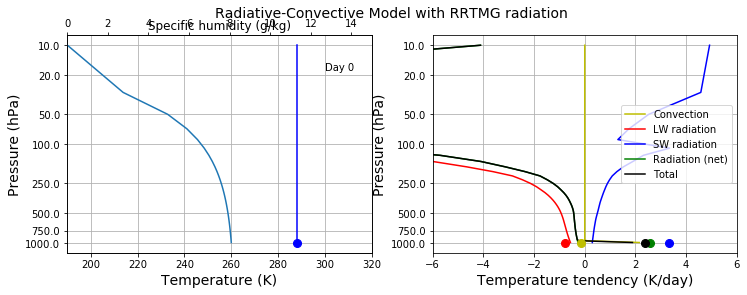

In [19]:
#  Start from isothermal state
rcm.state.Tatm[:] = rcm.state.Ts
#  Call the diagnostics once for initial plotting
rcm.compute_diagnostics()
#  Plot initial data
fig, axes, lines = initial_figure(rcm)

### Now let's step forward in time and animate the solution

In [20]:
def animate(day, model, lines):
    model.step_forward()
    lines[0].set_xdata(model.Tatm)
    lines[1].set_xdata(model.Ts)
    lines[2].set_xdata(model.q*1E3)
    tendencies_atm, tendencies_sfc = get_tendencies(model)
    for i, name in enumerate(tendencies_atm):
        lines[3+i].set_xdata(tendencies_atm[name])
    for i, name in enumerate(tendencies_sfc):
        lines[3+5+i].set_xdata(tendencies_sfc[name])
    lines[-1].set_text('Day {}'.format(int(model.time['days_elapsed'])))
    return lines   

In [21]:
ani = animation.FuncAnimation(fig, animate, frames=np.arange(1, 150), fargs=(rcm, lines))

In [22]:
HTML(ani.to_html5_video())

Plenty of interesting things to see in this animation! Discuss...

### The final figure, in case the animation isn't working

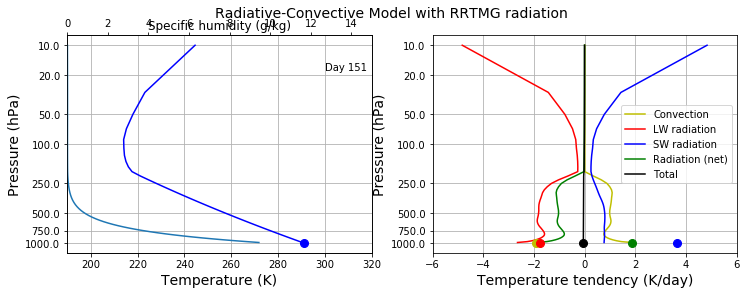

In [23]:
fig

### Reaching R-C equilibrium

The model is settling down after 150 days but is not really at equilibrium:

In [24]:
rcm.ASR - rcm.OLR

array([-7.89368757])

So we will integrate it out further (without animation):

In [25]:
rcm.integrate_years(2)
rcm.ASR - rcm.OLR

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 2.41209805439 years.


array([-0.00035076])

In [26]:
#  The equilibrated surface temperature
rcm.Ts

Field([ 286.95964264])

### Plot the equilibrium

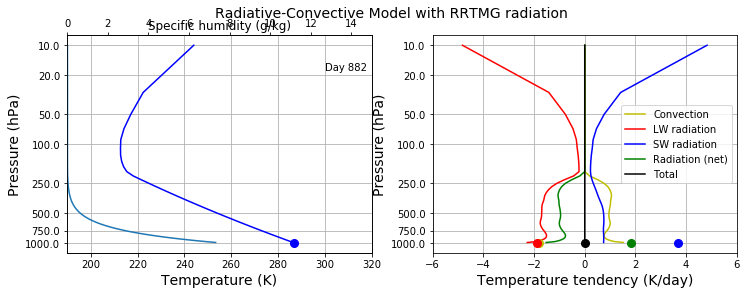

In [27]:
animate(0, rcm, lines)
fig

____________
<a id='section3'></a>

## 3. Forcing and feedback in the RCM
____________

In [28]:
#  Make a clone of our model and double CO2
rcm2 = climlab.process_like(rcm)
rcm2.subprocess['Radiation'].absorber_vmr['CO2'] *= 2.
#  Current CO2 concentration in ppmv
print rcm2.subprocess['Radiation'].absorber_vmr['CO2'] * 1E6

696.0


In [29]:
#  Compute radiation forcing
rcm2.compute_diagnostics()
#  There are now changes in both longwave and shortwave from the increased CO2
DeltaOLR = rcm2.OLR - rcm.OLR
DeltaASR = rcm2.ASR - rcm.ASR
print DeltaOLR, DeltaASR

[-2.58247533] [ 0.05647402]


In [30]:
#  The radiative forcing includes both LW and SW components
RF = DeltaASR - DeltaOLR
print 'The radiative forcing for doubling CO2 is %0.2f W/m2.' % (RF)

The radiative forcing for doubling CO2 is 2.64 W/m2.


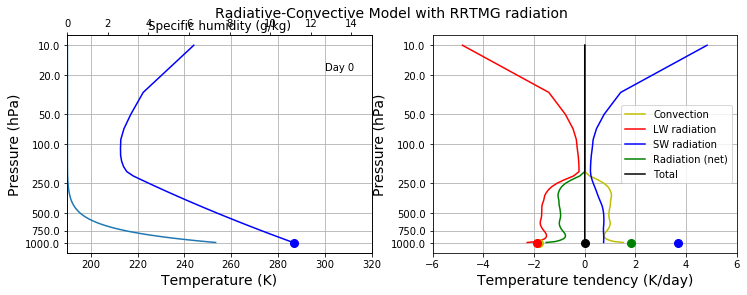

In [31]:
#  Plot initial data
fig, axes, lines = initial_figure(rcm2)

You have to look carefully to see this differences from the equilibrated model above. But the LW cooling rate is *just a little smaller*.

### Adjustment after doubling CO2

In [32]:
rcm_2xCO2 = climlab.process_like(rcm2)

In [33]:
ani_2xCO2 = animation.FuncAnimation(fig, animate, frames=np.arange(1, 100), fargs=(rcm_2xCO2, lines))

In [34]:
HTML(ani_2xCO2.to_html5_video())

Ok, it's a bit like watching paint dry but the model is warming up.

#### Plot final figure, in case the animation isn't working

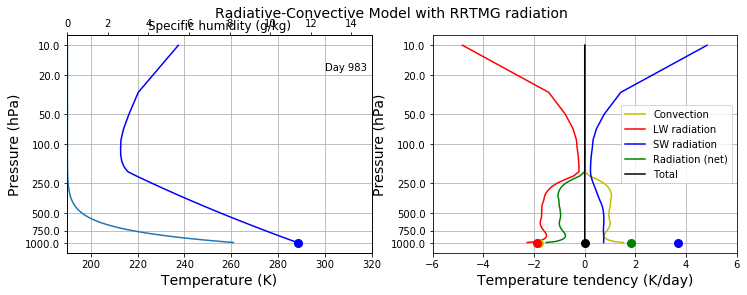

In [35]:
fig

### Integrate out to equilibrium:

In [36]:
rcm_2xCO2.ASR - rcm_2xCO2.OLR

array([ 1.02848298])

In [37]:
rcm_2xCO2.integrate_years(2)
rcm_2xCO2.ASR - rcm_2xCO2.OLR

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 4.69003855524 years.


array([ -2.30348519e-07])

In [38]:
DeltaTs = float(rcm_2xCO2.Ts - rcm.Ts)
print 'The equilibrium climate sensitivity is {:0.2f} K.'.format(DeltaTs)

The equilibrium climate sensitivity is 2.28 K.


### Plot the equilibrium

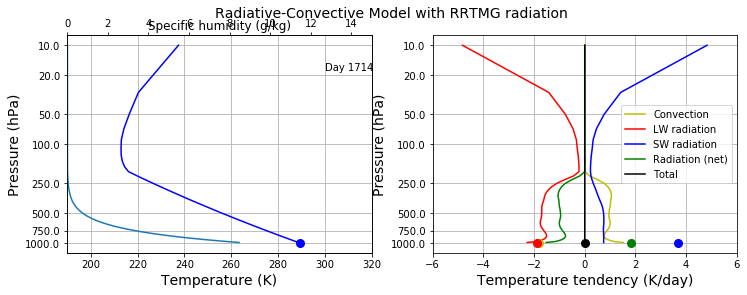

In [39]:
animate(0, rcm_2xCO2, lines)
fig

____________
<a id='section4'></a>

## 4. The role of water vapor in the warming
____________


In [40]:
rcm_noH2O = climlab.process_like(rcm2)
rcm_noH2O.remove_subprocess('WaterVapor')
print rcm_noH2O

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Tatm: (50,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Convection: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>



The specific humidity profile is now fixed.

In [41]:
rcm_noH2O.integrate_years(2)
rcm_noH2O.ASR - rcm_noH2O.OLR

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 4.4135097204 years.


array([  2.32844116e-07])

Let's double-check to see if the specific humidity field changed.

In [42]:
rcm_noH2O.subprocess['Radiation'].specific_humidity == rcm2.subprocess['Radiation'].specific_humidity

Field([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True], dtype=bool)

In [43]:
DeltaTs_noH2O = float(rcm_noH2O.Ts - rcm.Ts)
print 'The equilibrium climate sensitivity without water vapor feedback is {:0.2f} K.'.format(DeltaTs_noH2O)

The equilibrium climate sensitivity without water vapor feedback is 1.34 K.


## Some questions to pursue:

- How would you quantify the water vapor feedback in this model?
- What determines the strength of the water vapor feedback?
- What if the distribution of relative humidity changes a little bit as part of the global warming response?

We can investigate this last question actively with our model.

____________
<a id='section5'></a>

## 5. Observed relative humidity profiles
____________

### What is the prescribed Relative Humidity profile in our model, and how does it compare to observations?

In [119]:
import xarray as xr
from xarray.ufuncs import cos, deg2rad, log, exp

In [62]:
# This will try to read the data over the internet.
ncep_filename = 'rhum.mon.1981-2010.ltm.nc'
#  to read over internet
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/"
path = ncep_url
#  Open handle to data
ncep_rhum = xr.open_dataset( path + ncep_filename, decode_times=False )

In [63]:
ncep_rhum

<xarray.Dataset>
Dimensions:             (lat: 73, level: 8, lon: 144, nbnds: 2, time: 12)
Coordinates:
  * level               (level) float32 1000.0 925.0 850.0 700.0 600.0 500.0 ...
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 ...
  * lat                 (lat) float32 90.0 87.5 85.0 82.5 80.0 77.5 75.0 ...
  * time                (time) float64 -6.571e+05 -6.57e+05 -6.57e+05 ...
  * nbnds               (nbnds) int64 0 1
Data variables:
    climatology_bounds  (time, nbnds) float64 ...
    rhum                (time, level, lat, lon) float64 ...
    valid_yr_count      (time, level, lat, lon) float64 ...
Attributes:
    description: Data from NCEP initialized reanalysis (4x/day).  These are interpolated to pressure surfaces from model (sigma) surfaces
    platform: Model
    Conventions: COARDS
    not_missing_threshold_percent: minimum 3% values input to have non-missing output value
    history: Created 2011/07/12 by doMonthLTM
Converted to chunked, defl

In [83]:
#  Weighting for global average
weight = cos(deg2rad(ncep_rhum.lat)) / cos(deg2rad(ncep_rhum.lat)).mean(dim='lat')

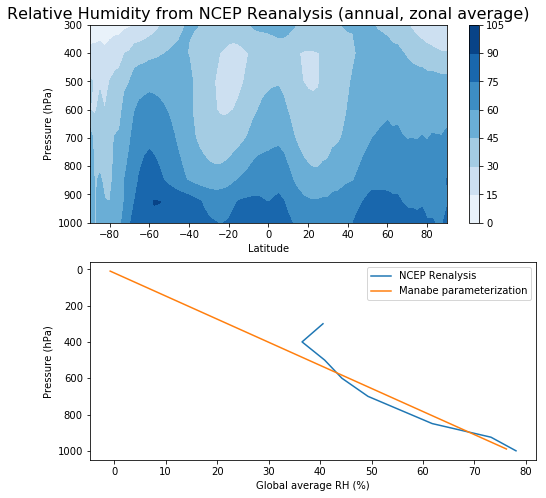

In [101]:
fig, axes = plt.subplots(2,1, figsize=(8,8))
ax = axes[0]
cax = ax.contourf(ncep_rhum.lat, ncep_rhum.level, 
                  ncep_rhum.rhum.mean(dim=('lon', 'time')),
                  cmap=plt.cm.Blues)
fig.colorbar(cax, ax=ax)
ax.set_xlabel('Latitude')
ax.set_title('Relative Humidity from NCEP Reanalysis (annual, zonal average)', fontsize=16)

ax = axes[1]
ax.plot((ncep_rhum.rhum*weight).mean(dim=('lon', 'time', 'lat')), 
        ncep_rhum.level, label='NCEP Renalysis')
# Overlay a plot of the prescribed RH profile in our model:
ax.plot(wv.RH_profile*100., wv.lev, label='Manabe parameterization')
ax.set_xlabel('Global average RH (%)')
ax.legend()

for ax in axes:
    ax.invert_yaxis()
    ax.set_ylabel('Pressure (hPa)')

____________
<a id='section5'></a>

## 6. Exercises on water vapor
____________

Suppose that (for reasons that are unresolved in our model) the RH profile changes. 

Specifcally let's consider a layer of (relatively) moister air in the upper troposphere, which we will implement as a Gaussian perturbation centered at 300 hPa:

In [134]:
# Gaussian bump centered at 300 hPa
def rh_pert(lev):
    return 0.2 * exp(-(lev-300.)**2/(2*50.)**2)

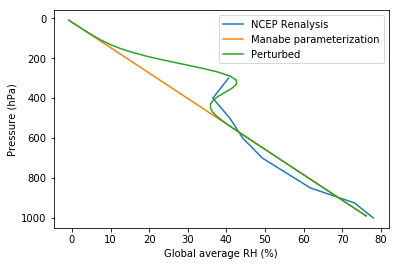

In [135]:
fig,ax = plt.subplots()
ax.plot((ncep_rhum.rhum*weight).mean(dim=('lon', 'time', 'lat')), 
        ncep_rhum.level, label='NCEP Renalysis')
# Overlay a plot of the prescribed RH profile in our model:
ax.plot(h2o.RH_profile*100., h2o.lev, label='Manabe parameterization')
ax.plot((h2o.RH_profile + rh_pert(h2o.lev))*100., wv.lev, label='Perturbed')
ax.set_xlabel('Global average RH (%)')
ax.legend()
ax.invert_yaxis()
ax.set_ylabel('Pressure (hPa)')

### Investigate how this layer of relatively moister air will affect the climate sensitivity

<div class="alert alert-success">
[Back to ATM 623 notebook home](../index.ipynb)
</div>

____________
## Credits

The author of this notebook is [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It was developed in support of [ATM 623: Climate Modeling](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/), a graduate-level course in the [Department of Atmospheric and Envionmental Sciences](http://www.albany.edu/atmos/index.php), offered in Spring 2015.
____________

____________
## Version information
____________


In [44]:
%load_ext version_information
%version_information numpy, matplotlib, climlab

Software versions
Python 2.7.12 64bit [GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]
IPython 5.1.0
OS Darwin 16.4.0 x86_64 i386 64bit
numpy 1.11.1
matplotlib 2.0.0
climlab 0.5.1dev0
Thu Mar 09 11:53:19 2017 EST